Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [x] Add your own stretch goal(s) !
  - [x] Pipelines!
- [ ] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [4]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [5]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [6]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [7]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [8]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## Task 1
- Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [9]:
# String to date time for year comparison
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [10]:
train_set = df[df['Date'].dt.year <= 2016]
validation_set = df[df['Date'].dt.year == 2017]
test_set = train_set = df[df['Date'].dt.year >= 2018]

## Task 2
- Begin with baselines for classification.

In [11]:
target = 'Great'
y_train = train_set[target]
y_train.value_counts(normalize=True)


True     0.578947
False    0.421053
Name: Great, dtype: float64

## Task 3
- Use scikit-learn for logistic regression

In [12]:
def split_x_y(df):
    """ Split label off of feature list"""
    
    target = 'Great'
    x = df.drop(target, axis = 1)
    y = df[target]
    return {'x':x, 'y':y}

In [13]:
train = split_x_y(train_set)
val = split_x_y(validation_set)
test = split_x_y(test_set)

In [14]:
from sklearn.metrics import accuracy_score

y_val = validation_set[target]
y_pred = [True] * len(y_val)
accuracy_score(y_val, y_pred)

0.4470588235294118

In [15]:
# Get columns that are numerical so they can be scaled and imputed
number_columns = train['x'].select_dtypes(include='number').dropna(1, "all").columns.to_list()

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

In [17]:
imputer.fit(train['x'][number_columns])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [18]:
x_sets = [train, val, test]

In [19]:
for x in x_sets:
    x['x'][number_columns] = pd.DataFrame(imputer.transform(x['x'][number_columns]), columns=number_columns, index = x['x'].index)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
scaler.fit(train['x'][number_columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:

for x in x_sets:
    x['x'][number_columns] = scaler.transform(x['x'][number_columns])

In [23]:
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(use_cat_names=True, drop_invariant=True)

In [24]:
# Use One Hot encoder to change columns of "x" and "nan" to 1 and 0
encoder.fit(train['x'])

OneHotEncoder(cols=['Burrito', 'Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico',
                    'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken',
                    'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato',
                    'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
                    'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
                    'Chile relleno', 'Nopales', ...],
              drop_invariant=True, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [25]:
# Nan Columns are already included in (feature)_x column.
# remove columns that include "nan"
for x in x_sets:
    x['oh'] = encoder.transform(x['x'])

oh_columns = encoder.get_feature_names()

In [26]:
nan_columns = [col for col in train['oh'].columns if "nan" in col]
nan_columns += ['Date', 'Mass (g)', 'Density (g/mL)', 'Queso']

for x in x_sets:
    x['no_nan'] = x['oh'].drop(nan_columns, axis=1)

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [28]:
model.fit(train['no_nan'], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## task 4
- Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [29]:
from sklearn.metrics import accuracy_score
def calculate_accuracy(X, y):
    y_pred = model.predict(X)
    return accuracy_score(y_pred, y)

In [30]:
from sklearn.metrics import accuracy_score

# Validation set accuracy
calculate_accuracy(val['no_nan'], val['y'])

0.7764705882352941

In [31]:
# Test set accuracy
calculate_accuracy(test['no_nan'], test['y'])

0.9210526315789473

# Stretch Goals
- Pipelines

In [32]:
train_p = split_x_y(train_set)
val_p = split_x_y(validation_set)
test_p = split_x_y(test_set)

In [33]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin

In [34]:
class NumericalIdentifier(TransformerMixin):

    def __init__(self, include:bool=True):
        self.column_names_ = None
        self.include = include

    def fit(self, X, y=None, **fit_params):
        if self.include:
            self.column_names_ = X.select_dtypes(include='number').dropna(1, "all").columns.to_list()
        else:
            self.column_names_ = X.select_dtypes(exclude='number').dropna(1, "all").columns.to_list()
        return self

    def transform(self, X):
        return X[self.column_names_]


In [35]:
class NanColumnRemover(TransformerMixin):

    def init(self):
        self.column_names_ = None

    def fit(self, X, y=None, **fit_params):
        self.column_names_ = [col for col in X.columns if "nan" in col]
        return self

    def transform(self, X):
        return X.drop(self.column_names_, axis = 1)


In [36]:
class ColumnDropper(TransformerMixin):

    def __init__(self):
        self.to_drop = ['Date', 'Mass (g)', 'Density (g/mL)', 'Queso']

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X.drop(self.to_drop, axis = 1)

In [37]:
numerical_pipe = make_pipeline(NumericalIdentifier(), SimpleImputer(), StandardScaler())

In [38]:
categorical_pipe = make_pipeline(NumericalIdentifier(False), OneHotEncoder(use_cat_names=True), NanColumnRemover())

In [39]:
union = make_union(numerical_pipe, categorical_pipe)

In [40]:
classifier = make_pipeline(ColumnDropper(), union, LogisticRegression())

In [41]:
classifier.fit(train_p['x'], train_p['y'])

Pipeline(memory=None,
         steps=[('columndropper',
                 <__main__.ColumnDropper object at 0x7f4a6b80fa90>),
                ('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('numericalidentifier',
                                                                  <__main__.NumericalIdentifier object at 0x7f4a6b80ff50>),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                

In [42]:
classifier.score(val_p['x'], val_p['y'])

0.7764705882352941

In [43]:
classifier.score(test_p['x'], test_p['y'])

0.9210526315789473

## Coefficients

In [68]:
coefs = pd.Series(classifier[-1].coef_[0], train['no_nan'].columns)
coefs_df = pd.DataFrame(coefs, columns = ['value']).sort_values('value')

In [69]:
coefs_df = coefs_df.reset_index()

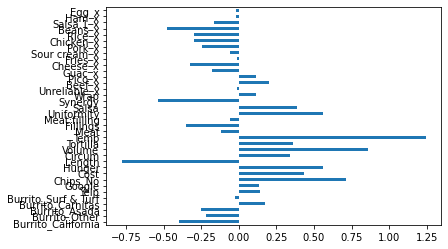

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

coefs.plot(kind='barh')

In [71]:
from plotly import express as px

In [72]:
px.bar(
    coefs_df,
    y = 'index',
    x = 'value',
    orientation='h'
)